<header style="width:100%;position:relative">
  <div style="width:80%;float:right;">
    <h1>False Political Claim Detection</h1>
    <h3>Entrenamiento y evaluación de los modelos</h3>
    <h5>Grupo 2</h5>
  </div>
        <img style="width:15%;" src="./images/logo.jpg" alt="UPM" />
</header>

# Índice

1. [Importar librerias](#1.-Importar-librerias)
2. [Variables globales y funciones auxiliares](#2.-Variables-globales-y-funciones-auxiliares)
3. [Carga del dataframe](#3.-Carga-del-dataframe)
4. [Selección de las características](#4.-Seleccion-de-las-caracteristicas)
5. [Carga de los datos y división en entrenamiento y test](#5.-Carga-de-los-datos-y-division-en-entrenamiento-y-test)
6. [Preprocesado](#6.-Preprocesado)
    * 6.1 [Tratamiento de los textos](#6.1-Tratamiento-de-los-textos)
    * 6.2 [Remuestreo](#6.2-Remuestreo)
7. [Modelos seleccionados](#7.-Modelos-seleccionados)
    * 7.1 [Introducción](#7.1-Introduccion)
    * 7.2 [Asignacion de las variables](#7.2-Asignacion-de-las-variables)
    * 7.3 [Clasificador Random Forest](#7.3-Clasificador-Random-Forest)
8. [Exportar CSV](#8.-Exportar-CSV)
    * 8.1 [Asignacion de las variables](#8.1-Asignacion-de-las-variables)
    * 8.2 [Clasificador Random Forest](#8.2-Clasificador-Random-Forest)
9. [Referencias](#9.-Referencias)

# 1. Importar librerias

In [563]:
# General import and load data
import pandas as pd
import numpy as np

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Splitting
from sklearn.model_selection import train_test_split

# Estimators
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score, recall_score, roc_curve, roc_auc_score

# Optimization
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# Visualization
import matplotlib.pyplot as plt

# Time optimization
import time

# word2vec
from gensim.models import Word2Vec
import gensim
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import word_tokenize


print("Todas las librerias fueron correctamente importadas.")

Todas las librerias fueron correctamente importadas.


# 2. Variables globales y funciones auxiliares

Se fija un seed para todo el documento para fijar la aleatoriedad y así obtener resultados replicables.

In [497]:
seed = 42

Función utilizado para evaluar los distintos umbrales en la curva de ROC.

In [498]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

# 3. Carga del dataframe

Se cargan los datos de la ruta *formated/train_exportado.csv*, los cuales son los datos ya procesados por uno de nuestros compañeros.

In [499]:
url = "formated/train_exportado.csv"
df = pd.read_csv(url)

print("Datos cargados correctamente\n")

Datos cargados correctamente



También cargamos el test que debemos predecir para Kaggle de la ruta *formated/test_exportado.csv*.

In [500]:
url = "formated/test_exportado.csv"
df_test = pd.read_csv(url)

print("Test cargado correctamente\n")

Test cargado correctamente



# 4. Seleccion de las caracteristicas

En el siguiente array se muestran todas las caracteristicas por si se decide realizar pruebas con otras *features*.

In [501]:
all_features = [
    # Identificador
    'id',

    # Etiqueta objetivo
    'label',

    # Texto original y procesado
    'statement', 'statement-raw', 'statement-lemmatize', 

    # Features derivados del texto
    'statement-ner', 'feelings',

    # One-hot encoded de los temas reagrupados del texto 
    'subject-ciencia_y_tecnologia', 'subject-economia_y_finanzas',
    'subject-educacion', 'subject-medio_ambiente_y_energia', 'subject-otros',
    'subject-politica_y_gobierno', 'subject-relaciones_internacionales',
    'subject-salud_y_bienestar', 'subject-seguridad_y_justicia',
    'subject-sociedad_y_cultura', 'subject-trabajo_y_empleo',

    # Resto de las categoricas agrupadas
    'speaker_grouped', 'speaker_job_grouped', 'state_info_grouped', 'party_group',

    # Resto de las categoricas agrupadas y codificadas
    'speaker_grouped_cod', 'speaker_job_grouped_cod',
    'state_info_grouped_cod', 'party_group_cod',

    # Variables generadas por LLM los null
    'speaker_job-llm', 'speaker_job_cod-llm',
    'state_info-llm', 'state_info_cod-llm',
    'party_affiliation-llm', 'party_affiliation_cod-llm'
]

Se seleccionan todas las categorias menos: 
* ***id***: no aporta ningún valor.
* ***label***: variable a predecir.
* ***statement***: esta *feature* esta por si nos es necesario en algun momento futuro tener el texto sin procesar.
* ***statement-lemmatize***: esta *feature* solo esta para probar en notebooks posteriores si clasifica mejor o peor con las raices de las palabras.
* ***statement-ner***: esta *feature* esta para ver si el clasificador funciona mejor con el NER por separado.
* ***speaker_grouped***, ***speaker_job_grouped***, ***state_info_grouped***, ***party_group***: suponemos que tenemos la misma información ya codificada.
* ***speaker_job-llm***, ***speaker_job_cod-llm***, ***state_info-llm***, ***state_info_cod-llm***, ***party_affiliation-llm***, ***party_affiliation_cod-llm***: esta información ya esta en otras *features*, la diferencia esta en como se tratan los nulos asi que se analizará cual funciona mejor si con LLM o sin ellos durante el apartado de clasificación.

In [502]:
selected_features = [
    # Texto
    'statement-raw',
    'statement-lemmatize',
    # Features derivados del texto
    'feelings',

    # One-hot encoded de los temas reagrupados del texto 
    'subject-ciencia_y_tecnologia', 'subject-economia_y_finanzas',
    'subject-educacion', 'subject-medio_ambiente_y_energia', 'subject-otros',
    'subject-politica_y_gobierno', 'subject-relaciones_internacionales',
    'subject-salud_y_bienestar', 'subject-seguridad_y_justicia',
    'subject-sociedad_y_cultura', 'subject-trabajo_y_empleo',

    # Resto de las categoricas agrupadas y codificadas
    'speaker_grouped_cod', 'speaker_job_grouped_cod',
    'state_info_grouped_cod', 'party_group_cod'
]

En caso de querer probar si funcionan mejor las de los LLM, se sustituirán por su simil. También si se quiere probar el texto lematizado se sustituira por el *raw*.

De las cuales texto es:

In [503]:
text = 'statement-raw'

Y las que no se corresponden con texto son:

In [504]:
no_text = [
    # Features derivados del texto
    'feelings',

    # One-hot encoded de los temas reagrupados del texto 
    'subject-ciencia_y_tecnologia', 'subject-economia_y_finanzas',
    'subject-educacion', 'subject-medio_ambiente_y_energia', 'subject-otros',
    'subject-politica_y_gobierno', 'subject-relaciones_internacionales',
    'subject-salud_y_bienestar', 'subject-seguridad_y_justicia',
    'subject-sociedad_y_cultura', 'subject-trabajo_y_empleo',

    # Resto de las categoricas agrupadas y codificadas
     'speaker_grouped_cod', 'speaker_job_grouped_cod',
     'state_info_grouped_cod', 'party_group_cod'
]

Y de las cuales, numéricas son las siguientes:

In [505]:
numeric_vars = [
    'speaker_grouped_cod', 'speaker_job_grouped_cod',
    'state_info_grouped_cod', 'party_group_cod'
]

# 5. Carga de los datos y division en entrenamiento y test

Cargamos las caracteristicas seleccionadas en la variable X y el objetivo *Accept* en la variable y.

In [506]:
X = df[selected_features] 
y = df['label'].values

Se separa ya en entrenamiento y test para no falsear los datos del test al realizar el balanceo.

In [507]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

A la hora de subir el modelo a Kaggle, ya se nos da dividido el entrenamiento y el test. Por ello, se utilizarán todos los datos tratados como entrenamiento (aunque también se le aplicará el mejor caso de preprocesado para cada modelo).

In [508]:
X_train_final = X
y_train_final = y

X_test_final = df_test[selected_features] 

# 6. Preprocesado

Como se menciona en el notebook dedicado al preprocesamiento, primero se tratará el texto, después se reducirá su dimensionalidad con un *TruncatedSVD*, se estandarizarán las variables codificadas mediante un *StandardScaler* y, finalmente, se realizará un remuestreo mediante *SMOTE* y *RandomUnderSampler*. 

En caso de querer probar el caso de preprocesamiento 6, será necesario eliminar el *StandardScaler* junto al *ColumnTransformer*.

## 6.1 Tratamiento de los textos

### 6.1.1 Vectorización

Primero tokenizamos el texto para Word2Vec

In [509]:
# Tokeniza el texto 
X_train_tokens = X_train[text].apply(lambda x: x.split())
X_test_tokens = X_test[text].apply(lambda x: x.split())


In [510]:
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=200, window=5, min_count=2, workers=4, seed=seed)


# Palabras conocidas
vocab = set(w2v_model.wv.index_to_key)

def sentence_vector(tokens, model, size=200):
    vectors = [model.wv[w] for w in tokens if w in vocab]
    if len(vectors) == 0:
        return np.zeros(size)
    else:
        return np.mean(vectors, axis=0)

# Aplica a train y test
X_txt_train = np.vstack(X_train_tokens.apply(lambda x: sentence_vector(x, w2v_model)))
X_txt_test = np.vstack(X_test_tokens.apply(lambda x: sentence_vector(x, w2v_model)))


Después para el dataset que se utilizará para subir a Kaggle.

In [511]:
# Tokeniza el texto 
X_train_tokens_final = X_train_final[text].apply(lambda x: x.split())
X_test_tokens_final = X_test_final[text].apply(lambda x: x.split())

In [512]:
w2v_model_final = Word2Vec(sentences=X_train_tokens_final, vector_size=200, window=5, min_count=2, workers=4, seed=seed)


# Palabras conocidas
vocab_final = set(w2v_model_final.wv.index_to_key)

def sentence_vector(tokens, model, size=200):
    vectors = [model.wv[w] for w in tokens if w in vocab_final]
    if len(vectors) == 0:
        return np.zeros(size)
    else:
        return np.mean(vectors, axis=0)

# Aplica a train y test
X_txt_tr_final = np.vstack(X_train_tokens_final.apply(lambda x: sentence_vector(x, w2v_model_final)))
X_txt_te_final = np.vstack(X_test_tokens_final.apply(lambda x: sentence_vector(x, w2v_model_final)))




### 6.1.2 Unificación de características

In [513]:

# Train
X_svd_train = pd.DataFrame(X_txt_train, columns=[f"svd_{i}" for i in range(X_txt_train.shape[1])])
X_rest_train = X_train[no_text].reset_index(drop=True)

# Test
X_svd_test = pd.DataFrame(X_txt_test, columns=[f"svd_{i}" for i in range(X_txt_test.shape[1])])
X_rest_test = X_test[no_text].reset_index(drop=True)

# Text + Resto de features
X_total_train = pd.concat([X_svd_train, X_rest_train], axis=1)
X_total_test = pd.concat([X_svd_test, X_rest_test], axis=1)

Ahora kaggle

In [514]:
# Train
X_svd_tr_final = pd.DataFrame(X_txt_tr_final, columns=[f"svd_{i}" for i in range(X_txt_tr_final.shape[1])])
X_rest_tr_final = X_train_final[no_text].reset_index(drop=True)

# Test
X_svd_te_final = pd.DataFrame(X_txt_te_final, columns=[f"svd_{i}" for i in range(X_txt_te_final.shape[1])])
X_rest_te_final = X_test_final[no_text].reset_index(drop=True)

# Text + Resto de features
X_tot_tr_final = pd.concat([X_svd_tr_final, X_rest_tr_final], axis=1)
X_tot_te_final = pd.concat([X_svd_te_final, X_rest_te_final], axis=1)

## 6.2 Remuestreo

### 6.2.1 Estandarizacion

Primero se estandarizan el conjunto para el análisis.

In [515]:
prep = ColumnTransformer([
    ('numericas', StandardScaler(), numeric_vars)
], remainder='passthrough').fit(X_total_train) 

X_scaled_train = prep.transform(X_total_train)
X_scaled_test = prep.transform(X_total_test)

Después el de Kaggle.

In [516]:
prep_final = ColumnTransformer([
    ('numericas', StandardScaler(), numeric_vars)
], remainder='passthrough').fit(X_tot_tr_final) 

X_scaled_tr_final = prep_final.transform(X_tot_tr_final)
X_scaled_te_final = prep_final.transform(X_tot_te_final)

### 6.2.2 Undersampling

Primero se realiza un undersampling al conjunto para el análisis.

In [517]:
under = RandomUnderSampler(sampling_strategy=0.65, random_state=seed)
X_under, y_under = under.fit_resample(X_scaled_train, y_train)

c:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\david\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\david\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Después el de Kaggle.

In [518]:
under_final = RandomUnderSampler(sampling_strategy=0.8, random_state=seed)
X_under_final, y_under_final = under_final.fit_resample(X_scaled_tr_final, y_train_final)

c:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\david\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\david\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


### 6.2.3 Oversampling

Primero se realiza un oversampling al conjunto para el análisis.

In [519]:
over = SMOTE(sampling_strategy=0.8, random_state=seed)
X_resampled, y_resampled = over.fit_resample(X_under, y_under)

c:\Users\david\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Después el de Kaggle.

In [520]:
over_final = SMOTE(sampling_strategy=0.9, k_neighbors=5, random_state=seed)
X_res_final, y_res_final = over_final.fit_resample(X_under_final, y_under_final)

c:\Users\david\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


# 7. Modelos seleccionados

## 7.1 Introduccion

En el anterior notebook se evaluaron una serie de modelos tanto por F1 score como por ROC-AUC score. Los modelos con mejores resultados para ambas categorías fueron:
* Random Forest.
* GradientBoosting.
* XGBoost.
* LogisticRegression.
* SVC con kernel rbf.

Por lo tanto nos dispondremos a probar dichos modelos a continuación.

## 7.2 Asignacion de las variables

Asignamos las variables para el analisis en función del desarrollo del apartado del preprocesado.

In [521]:
X_model = X_resampled
y_model = y_resampled

X_model_test = X_scaled_test
expected = y_test

## 7.3 Clasificador Random Forest

### 7.3.1 Definicion

Definimos el modelo con los hiperparámetros *random_state* fijado y *class_weigth* balanceado. También se escoje *n_jobs* con valor -1 para utilizar todos los procesadores.

In [522]:
model_Forest = RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=seed)

### 7.3.2 Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [523]:
model_Forest.fit(X_model, y_model)

predicted_Forest = model_Forest.predict(X_model_test)

In [524]:
accuracy_score(expected, predicted_Forest)

0.6156424581005586

### 7.3.3 Null accuracy

Ahora se va a evaluar si  el modelo siempre predice la clase más frecuente.

In [525]:
s_y_test = pd.Series(y_test)
s_y_test.value_counts()

1    1179
0     611
Name: count, dtype: int64

In [526]:
y_test.mean()

0.658659217877095

In [527]:
1 - y_test.mean() 

0.341340782122905

In [528]:
max(y_test.mean(), 1 - y_test.mean())

0.658659217877095

In [529]:
s_y_test.value_counts().head(1) / len(y_test)

1    0.658659
Name: count, dtype: float64

Nuestra exactitud es de 0.626, la cual es peor que la *null accuracy*, es decir, ahora mismo no tenemos un buen modelo ya que se predecirían un mayor número de resultados en el caso de siempre predecir la clase mayoritaria.

### 7.3.4 Matriz de confusion y F-score

Se muestra la matriz de confusión y el informe de clasificación.

In [530]:
print(confusion_matrix(expected, predicted_Forest))

[[235 376]
 [312 867]]


In [531]:
print(classification_report(expected, predicted_Forest))

              precision    recall  f1-score   support

           0       0.43      0.38      0.41       611
           1       0.70      0.74      0.72      1179

    accuracy                           0.62      1790
   macro avg       0.56      0.56      0.56      1790
weighted avg       0.61      0.62      0.61      1790



Se observa que estamos identificando erroneamente los 0s ya que tenemos un f1-score del 0.74 para los 1s mientras que estamos obteniendo un 0.35 para los 0s

### 7.3.5 ROC y AUC

Evaluamos la ROC-AUC score. Para ello representamos primero la curva de ROC.

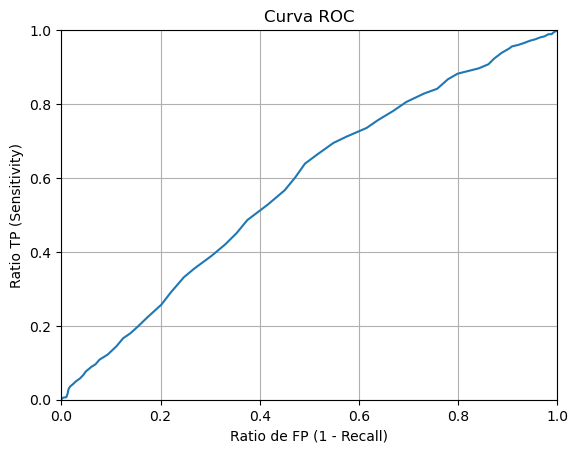

In [532]:
y_pred_prob_Forest = model_Forest.predict_proba(X_model_test)[:,1]
fpr, tpr, thresholds = roc_curve(expected, y_pred_prob_Forest)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

Y mostramos sus thresholds.

In [533]:
thresholds

array([ inf, 0.95, 0.94, 0.89, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81,
       0.8 , 0.79, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 ,
       0.69, 0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59,
       0.58, 0.57, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5 , 0.49, 0.48,
       0.47, 0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38, 0.37,
       0.36, 0.35, 0.34, 0.33, 0.32, 0.31, 0.3 , 0.29, 0.28, 0.27, 0.26,
       0.25, 0.23, 0.22, 0.17])

Como se observa el resultado no es bueno ya que estamos obteniendo practicamente una recta en vez de una curva en forma de 'L' invertida.

La siguiente gráfica muestra las probabilidades de predicción en función de los umbrales.

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

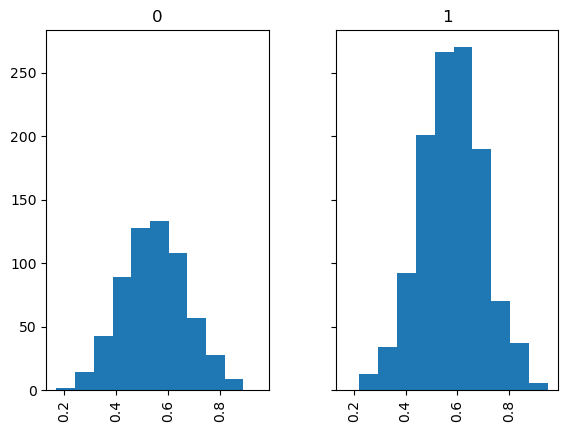

In [534]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_Forest, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

Se muestra que los mejores resultados para ambas clases se obtiene con el *threshold* igual a 0.5 aproximandamente (es decir, el valor por defecto).

In [535]:
best_thres_Random = 0.5

evaluate_threshold(best_thres_Random)

Sensitivity: 0.7353689567430025
Recall: 0.3846153846153846


Con este valor se obtienen los siguientes resultados. Primero se recalculan las predicciones.

In [536]:
probs_Forest = model_Forest.predict_proba(X_model_test)[:, 1]  
pred_thres_Forest = (probs_Forest >= best_thres_Random).astype(int) 

Se evalua la matriz de confusión.

In [537]:
print(confusion_matrix(expected, pred_thres_Forest))

[[221 390]
 [287 892]]


Y también se analiza el informe de la clasificación.

In [538]:
print(classification_report(expected, pred_thres_Forest))

              precision    recall  f1-score   support

           0       0.44      0.36      0.39       611
           1       0.70      0.76      0.72      1179

    accuracy                           0.62      1790
   macro avg       0.57      0.56      0.56      1790
weighted avg       0.61      0.62      0.61      1790



Obviamente son los mismos, ya que no estamos modificando el umbral realmente.

Finalmente se calcula el valor de AUC.

In [539]:
print(roc_auc_score(expected, predicted_Forest))

0.5599921706791935


Se ha obtenido un valor entre 0.5 y 0.6, es decir, el modelo se considerá como fallido o *F*.

### 7.3.6 Optimizacion

Antes de nada, observamos cuales son los parámetros de nuestro modelo.

In [540]:
model_Forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

También creemos que es interesante saber la profundidad media de nuestro modelo Random Forest, para así poder estimar mejor rango de valores en este apartado.

In [541]:
arboles_decision = model_Forest.estimators_

profundidades = [arbol.tree_.max_depth for arbol in arboles_decision]
profundidad_media = np.mean(profundidades)

print(f"Profundidad media de los árboles: {profundidad_media}")

Profundidad media de los árboles: 30.01


Ahora seleccionamos los hiperparámetros a evaluar mediante un GridSearchCV. Además, se ha añadido la librería *time* para saber el tiempo que tardo en realizar la busqueda de mejores parámetros.

Estos hiperparámetros son:
* ***n_estimator***: número de árboles.
* ***max_depth***: máxima profundidad de cada árbol.
* ***min_samples_split***: número de muestras mínimas para dividir un nodo interno.
* ***min_samples_leaf***: número de muestras mínimas de un nodo hoja.
* ***max_features***: número de características a tener en cuenta a la hora de buscar la mejor división.
* ***class_weight***: pesos asignados a las clases.

Se calcula el tiempo que ha tardado en minutos.

Se escoge el mejor parámetro y su  precisión asociada.

Observamos los mejores 10 casos para analizar varias posibilidades.

### 7.3.7 Entrenamiento y evaluacion con hiperparametros optimizados

#### - Definicion

Definimos los mejores parámetros (no se define con *grid_search.best_params_* para probar varias opciones de forma sencilla).

In [542]:
params_final_Forest = {
    'class_weight': 'balanced',
    'max_depth': 25,
    'max_features': 50,
    'min_samples_leaf': 4,
    'min_samples_split': 2,
    'n_estimators': 300,
    'n_jobs': -1,
    'random_state': seed
}

Definimos el modelo desagregando el diccionario.

In [543]:
final_Forest = RandomForestClassifier(**params_final_Forest)

#### - Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [544]:
final_Forest.fit(X_model, y_model)

predicted_For_opt = final_Forest.predict(X_model_test)

In [545]:
accuracy_score(expected, predicted_For_opt)

0.6201117318435754

#### - Null accuracy

La accuracy es similar a la anterior. Además, sigue siendo peor que la *null accuracy*.

#### - Matriz de confusion y F-score

La matriz de confusión y el informe de clasificación también es muy similar.

In [546]:
print(confusion_matrix(expected, predicted_For_opt))

[[260 351]
 [329 850]]


In [547]:
print(classification_report(expected, predicted_For_opt))

              precision    recall  f1-score   support

           0       0.44      0.43      0.43       611
           1       0.71      0.72      0.71      1179

    accuracy                           0.62      1790
   macro avg       0.57      0.57      0.57      1790
weighted avg       0.62      0.62      0.62      1790



#### - ROC y AUC

Se calcula el ROC y se reajusta el umbral de probabilidad.

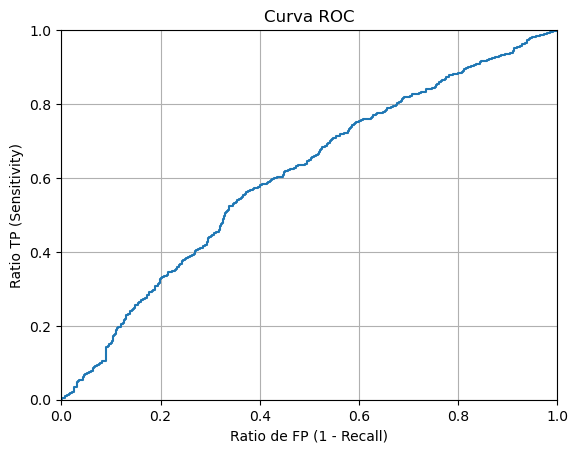

In [548]:
y_pred_prob_Forest = final_Forest.predict_proba(X_model_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_Forest)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

In [549]:
thresholds

array([       inf, 0.88340776, 0.87248997, 0.85401211, 0.84564977,
       0.84425551, 0.84261341, 0.8336565 , 0.83322093, 0.8261721 ,
       0.82368034, 0.82301509, 0.82136543, 0.81781761, 0.81714888,
       0.81400341, 0.81325457, 0.81191387, 0.81189117, 0.809436  ,
       0.80424282, 0.80119268, 0.79993294, 0.79880272, 0.79804934,
       0.7980159 , 0.79697338, 0.78171392, 0.78141804, 0.78037247,
       0.77997202, 0.77993458, 0.77911544, 0.76677485, 0.76603392,
       0.76587077, 0.76546578, 0.76425265, 0.76337043, 0.76271837,
       0.76140643, 0.75842076, 0.75763772, 0.75354894, 0.75299336,
       0.74879759, 0.7484282 , 0.74823497, 0.74755146, 0.74754585,
       0.74747929, 0.74692311, 0.74689811, 0.74676503, 0.74672595,
       0.74600302, 0.74581557, 0.74493409, 0.74433037, 0.74351482,
       0.74329694, 0.74307013, 0.74255258, 0.74215854, 0.74215697,
       0.73846047, 0.73692515, 0.73580015, 0.73541505, 0.73420248,
       0.73333933, 0.73322724, 0.73318475, 0.73232223, 0.73217

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

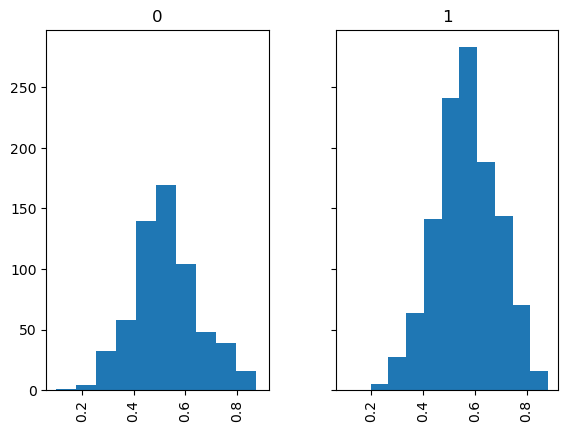

In [550]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_Forest, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [551]:
op_thres_Random = 0.5

evaluate_threshold(op_thres_Random)

Sensitivity: 0.720949957591179
Recall: 0.42553191489361697


In [552]:
probs_For_opt = final_Forest.predict_proba(X_model_test)[:, 1]  
pred_thres_For_opt = (probs_For_opt >= op_thres_Random).astype(int) 

In [553]:
print(confusion_matrix(expected, pred_thres_For_opt))

[[260 351]
 [329 850]]


In [554]:
print(classification_report(expected, pred_thres_For_opt))

              precision    recall  f1-score   support

           0       0.44      0.43      0.43       611
           1       0.71      0.72      0.71      1179

    accuracy                           0.62      1790
   macro avg       0.57      0.57      0.57      1790
weighted avg       0.62      0.62      0.62      1790



Se obtienen los mismos resultados porque sigue siendo el mejor caso con umbral igual a 0,5.

Se calcula la AUC score.

In [555]:
print(roc_auc_score(expected, predicted_For_opt))

0.5732409362423979


También ha tenido una pequeña mejora, pero sigue en el mismo intervalo. Es decir, sigue siendo un modelo *F*.

### 7.3.8 Conclusiones del modelo

Tal y como esta el modelo no se estan obteniendo buenos resultados debido a la escasez de entradas y la gran cantidad de dimensiones que presenta el dataset. Estamos obteniendo prácticamente los mismos resultados que si decidieramos clasificar al azar.

# 8. Exportar CSV

## 8.1 Asignacion de las variables

Asignamos las variables para el analisis en función del desarrollo del apartado del preprocesado.

In [556]:
X_kaggle = X_res_final
y_kaggle = y_res_final

X_kaggle_test = X_scaled_te_final

## 8.2 Clasificador Random Forest

Se entrena con los nuevos valores de train y test, y se modifica el umbral de probabilidades. En un principio, el valor del umbral era el de la variable *op_thres_Random*, pero se decidió finalmente que el valor del umbral fueran valores numéricos para que fuera más sencillo hacer diversas pruebas en Kaggle.

In [557]:
final_Forest.fit(X_kaggle, y_kaggle)

probs_For_final = final_Forest.predict_proba(X_kaggle_test)[:, 1]  
pred_thres_For_final = (probs_For_final >= 0.5).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [558]:
df_label_Random = pd.DataFrame(pred_thres_For_final, columns=['label'])

In [559]:
df_id = df_test['id'].reset_index(drop=True)

In [560]:
df_final_Random = pd.concat([df_id, df_label_Random], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [561]:
df_final_Random['label'].value_counts()

label
1    2172
0    1664
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [562]:
df_final_Random.to_csv('./submit/randomWord2vec.csv', index=False)

# 9. Referencias

* [ColumnTransformer. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
* [GridSearchCV. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [RandomForestClassifier. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [RandomUnderSampler — Version 0.13.0. (s. f.). Imbalance learn.](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html)
* [SMOTE — Version 0.13.0. (s. f.). Imbalanced learn.](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)
* [StandardScaler. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
* [train_test_split. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* [TfidfVectorizer. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* [TruncatedSVD. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)